In [1]:
import numpy as np
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import libtfr
import pointproc

/Users/dmeliza/.virtualenvs/akit/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def fmsin(N, fnormin, fnormax, period, t0, fnorm0, pm1):
    from numpy import sign, sin, arccos, exp, arange, pi, real
    fnormid = 0.5 * (fnormax+fnormin)
    delta = 0.5 * (fnormax-fnormin)
    phi = - sign(pm1) * arccos((fnorm0 - fnormid)/delta)
    t = arange(0.0, N)
    phase = 2 * pi * fnormid * (t - t0) + delta * period * (sin(2 * pi * (t - t0) / period + phi) - sin(phi))
    return real(exp(1j * phase))

sig = fmsin(17590, 0.15, 0.45, 1024, 256./4, 0.3, -1)

In [3]:
# an inhomogeneous poisson process with rate = exp(sig)
p = np.exp(sig - 1)
events = (p > np.random.uniform(size=p.size)).nonzero()[0].astype('d')
# jitter 
events += np.random.uniform(low=-0.25, high=0.25, size=events.size)

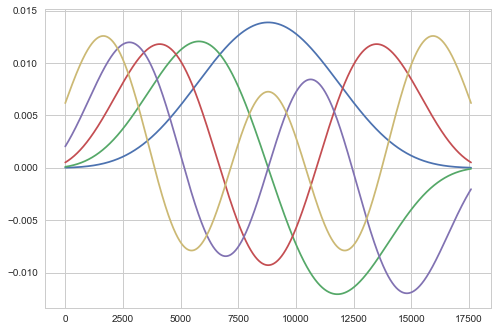

In [4]:
# generate some tapers
nfft = sig.size
ntapers = 5
transform = libtfr.mfft_dpss(nfft, 3, ntapers, nfft)
plt.plot(transform.tapers.T)

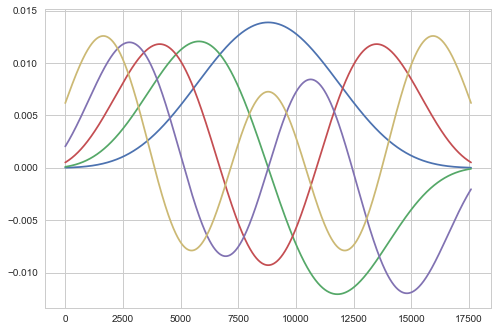

In [5]:
# test interpolation (used by point process fft)
start = 0
dt = 1
data = np.asarray(events, dtype='d')
h = transform.tapers
ht = pointproc.interpolate(h.T, data, 0, dt)
plt.plot(data, ht)

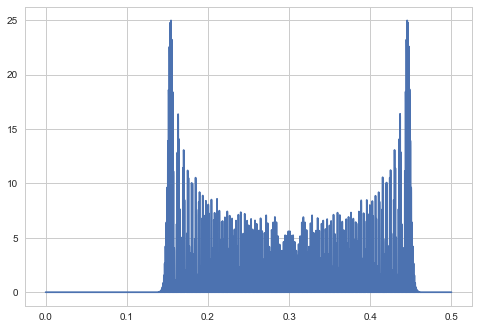

In [6]:
# transform a time series
Z = transform.mtpsd(sig)
f, idx = libtfr.fgrid(1, transform.nfft, [0, 0.5])
plt.plot(f, Z[idx])

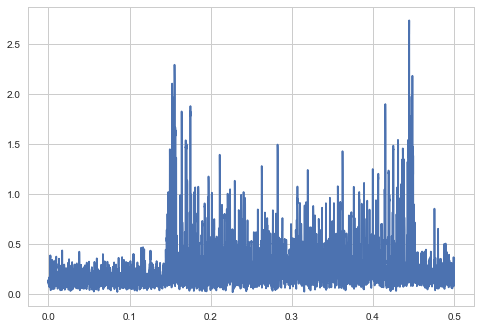

In [7]:
# this should look like a noisy version of the above signal
from dlab import pointproc as pp
J, Nsp, f = pp.mtfft([events], time_range=(0, sig.size), NW=3, k=ntapers, nfft=nfft)
S = np.mean(J * J.conj(), (1,2)).real
plt.plot(f, S)

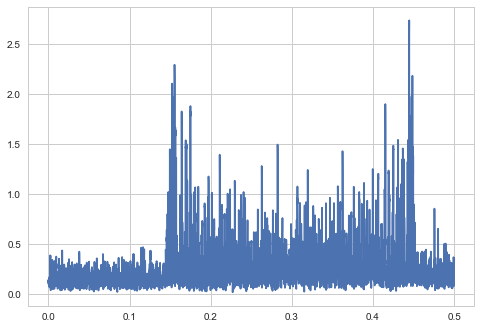

In [8]:
# point process fft - should look like noisy version of signal spectrum
JJ = transform.mtfft_pt(events, 0, sig.size)
SS = np.mean(JJ * JJ.conj(), 1).real
plt.plot(f, SS)

(129, 1734)


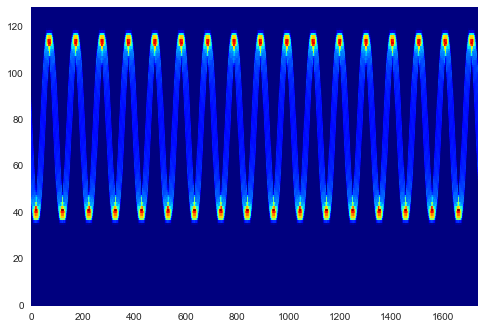

In [9]:
# spectrograms
sns.set_style("dark")
nfft = 256
shift = 10
ntapers = 5
nframes = (sig.size - nfft) // shift + 1
D = libtfr.mfft_dpss(nfft, 3, ntapers, nfft)
Z = D.mtspec(sig, shift)
print(Z.shape)
plt.imshow(Z, cmap="jet")

(129, 1734, 5)


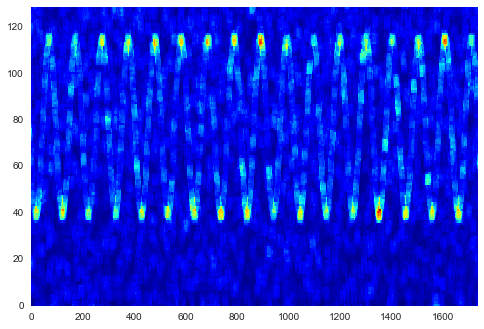

In [10]:
Z, Nsp = pointproc.mtstft_pt(D, events, nfft, shift, 0, sig.size)
S = (Z * Z.conj()).mean(2).real
print(Z.shape)
plt.imshow(S, cmap="jet")